In [2]:
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"

1.10.0+cu111
11.1


In [3]:
! pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
! pip -qq install focal-loss

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     |██████████████▋                 | 834.1 MB 1.4 MB/s eta 0:12:08tcmalloc: large alloc 1147494400 bytes == 0x562efef32000 @  0x7fef5b855615 0x562ec55294cc 0x562ec560947a 0x562ec552c2ed 0x562ec561de1d 0x562ec559fe99 0x562ec559a9ee 0x562ec552dbda 0x562ec559fd00 0x562ec559a9ee 0x562ec552dbda 0x562ec559c737 0x562ec561ec66 0x562ec559bdaf 0x562ec561ec66 0x562ec559bdaf 0x562ec561ec66 0x562ec559bdaf 0x562ec552e039 0x562ec5571409 0x562ec552cc52 0x562ec559fc25 0x562ec559a9ee 0x562ec552dbda 0x562ec559c737 0x562ec559a9ee 0x562ec552dbda 0x562ec559b915 0x562ec552dafa 0x562ec559bc0d 0x562ec559a9ee
     |██████████████████▌             | 1055.7 MB 1.3 MB/s eta 0:09:38tcmalloc: large alloc 1434370048 bytes == 0x562f43588000 @  0x7fef5b855615 0x562ec55294cc 0x562ec560947a 0x562ec552c2ed 0x562ec561de1d 0x562ec559fe99 0x562ec559a9ee 0x562ec552dbda 0x562ec559fd00 0x562ec559a9ee 0x562ec552dbda 0x562ec559c737 0x562ec561ec66 0x562e

In [4]:
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, Size

from torch import Tensor
from torch.nn import Linear
import torch.nn.functional as F
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import os
import time
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import softmax

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Muon project/new-smaples.csv').drop(columns = 'Unnamed: 0')
df = df.drop(columns = [i for i in df.columns if '_1' in i])
df['non_hits'] = df[[i for i in df.columns if 'mask' in i]].sum(axis=1)
df = df[df['non_hits']==0].reset_index(drop=True)

df['1/pT'] = df['q/pt'].abs()
def label(a):
    if a<=10:
        return 0
    if a>10 and a<=30:
        return 1
    if a>30 and a<=100:
        return 2
    if a>100:
        return 3

df['pT'] = 1/df['1/pT']
    
df['pT_classes'] = df['pT'].apply(label)

features = ['emtf_phi_'+str(i) for i in [0,2,3,4]] + ['emtf_theta_'+str(i) for i in [0,2,3,4]] + ['fr_'+str(i) for i in [0,2,3,4]] + ['old_emtf_phi_'+str(i) for i in [0,2,3,4]]
labels_1 = ['pT']
labels_2 = ['pT_classes']
labels_3 = ['vx']

scaler_1 = StandardScaler()
df[features] = scaler_1.fit_transform(df[features])

scaler_3 = MinMaxScaler()
df[labels_3] = scaler_3.fit_transform(df[labels_3])

In [8]:
df

,emtf_phi_0,emtf_phi_2,emtf_phi_3,emtf_phi_4,emtf_theta_0,emtf_theta_2,emtf_theta_3,emtf_theta_4,emtf_bend_0,emtf_bend_2,emtf_bend_3,emtf_bend_4,emtf_qual_0,emtf_qual_2,emtf_qual_3,emtf_qual_4,emtf_time_0,emtf_time_2,emtf_time_3,emtf_time_4,ring_0,ring_2,ring_3,ring_4,fr_0,fr_2,fr_3,fr_4,old_emtf_phi_0,old_emtf_phi_2,old_emtf_phi_3,old_emtf_phi_4,old_emtf_bend_0,old_emtf_bend_2,old_emtf_bend_3,old_emtf_bend_4,mask_0,mask_2,mask_3,mask_4,ipt,ieta,phi_median,theta_median,q/pt,phi,eta,vx,vy,vz,non_hits,1/pT,pT,pT_classes
0,0.694347,0.992312,1.032076,1.015820,0.874252,0.663437,0.594412,0.486451,7.0,1.0,0.0,0.0,6.0,6.0,-6.0,-5.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.010772,0.987201,-0.994134,-0.975562,0.660277,0.990405,1.028145,1.011871,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3846.0,27.0,-0.302635,-1.514912,1.879051,0.709254,0.000011,-2.967770,0.0,0.302635,3.304312,0
1,0.681941,0.651284,0.676773,0.675302,-0.753926,-0.801596,-0.777747,-0.788280,0.0,-4.0,-1.0,0.0,6.0,-6.0,6.0,6.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,1.010772,-1.012965,1.005900,1.025051,0.676465,0.647427,0.671868,0.671353,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3524.0,12.0,0.027368,3.016775,2.261755,0.409426,-0.000388,-4.839151,0.0,0.027368,36.538564,2
2,1.317535,1.630769,1.713638,1.735551,-0.658151,-0.703927,-0.875758,-0.886336,9.0,3.0,0.0,0.0,-6.0,3.0,-5.0,-6.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,-0.989343,0.987201,-0.994134,-0.975562,1.331572,1.625979,1.709718,1.731600,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4560.0,12.0,-0.376678,2.897855,2.153393,0.396130,0.000280,4.740714,0.0,0.376678,2.654788,0
3,1.559939,1.583297,1.581973,1.574966,-0.849701,-0.801596,-0.777747,-0.788280,-1.0,0.0,0.0,1.0,5.0,-6.0,5.0,6.0,0.0,0.0,-1.0,0.0,4.0,1.0,1.0,1.0,1.010772,-1.012965,1.005900,1.025051,1.551528,1.579473,1.578051,1.568113,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,4.0,0.0,4456.0,12.0,0.009413,-1.960714,2.260267,0.358034,-0.000800,-4.336885,0.0,0.009413,106.233878,3
4,-1.482517,-1.253432,-1.269166,-1.308796,1.832004,1.835463,1.868560,1.957295,6.0,0.0,-2.0,-3.0,6.0,-6.0,6.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.010772,-1.012965,1.005900,1.025051,-1.507860,-1.257357,-1.272165,-1.312740,-2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1511.0,40.0,-0.264267,3.072832,1.722160,0.365747,-0.000668,4.515598,0.0,0.264267,3.784045,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665315,-1.285922,-1.292185,-1.283688,-1.273002,-0.658151,-0.606258,-0.581724,-0.592168,15.0,0.0,0.0,1.0,-6.0,-6.0,5.0,6.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,-0.989343,-1.012965,1.005900,1.025051,-1.222203,-1.288361,-1.279910,-1.273077,-3.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,4.0,0.0,1488.0,14.0,-0.062339,-2.882165,-2.201211,0.404706,0.000348,-1.503398,0.0,0.062339,16.041309,1
665316,0.213357,0.528243,0.582864,0.597912,-0.179275,-0.215583,-0.189678,-0.101886,7.0,4.0,2.0,0.0,-6.0,-5.0,6.0,6.0,0.0,-1.0,0.0,0.0,1.0,1.0,1.0,1.0,-0.989343,-1.012965,1.005900,1.025051,0.244170,0.532132,0.585703,0.600735,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3367.0,19.0,-0.278606,-1.588400,-2.060806,0.603803,0.000839,-1.399982,0.0,0.278606,3.589296,0
665317,-0.525308,-0.191596,-0.095794,-0.059907,-0.849701,-0.996933,-1.071781,-1.180505,11.0,3.0,2.0,0.0,5.0,4.0,-4.0,-4.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,1.010772,0.987201,-0.994134,-0.975562,-0.542339,-0.186764,-0.095870,-0.055148,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2630.0,10.0,-0.488393,-0.901991,-2.287345,0.594092,0.000178,3.621619,0.0,0.488393,2.047531,0
665318,-0.935676,-0.966659,-0.966142,-0.965375,-1.041252,-1.094602,-1.071781,-1.082449,0.0,0.0,0.0,0.0,-6.0,-5.0,6.0,6.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,-0.989343,-1.012965,1.005900,1.025051,-0.933690,-0.962823,-0.962359,-0.961581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1826.0,9.0,0.036043,-2.703958,-2.324632,0.363957,-0.000187,-0.082033,0.0,0.036043,27.744874,1


In [ ]:
shuffled_list = list(range(len(df)))
random.Random(242).shuffle(shuffled_list)
shuffled_list = np.array_split(np.array(shuffled_list), 10)

In [ ]:
edge_index = torch.tensor([(0,1),(1,2),(2,3),(3,2),(2,1),(1,0)], dtype=torch.long).T
X_data = df[features].to_numpy()
Y_data = df[labels_1].to_numpy()
def process_data(i):
  graph = X_data[i].reshape(-1,4).T
  y = Y_data[i]
  data = Data(x=torch.tensor(graph, dtype=torch.float), y=torch.tensor(y, dtype=torch.float), edge_index=edge_index)
  return data

In [ ]:
class TriggerDataset(Dataset):
    def __init__(self, root, indexes=list(range(len(df))), transform=None, pre_transform=None):
        super(TriggerDataset, self).__init__(root, transform, pre_transform)
        self.indexes = indexes
        self.length = len(self.indexes)

    @property
    def raw_file_names(self):
        return ['vgc']

    @property
    def processed_file_names(self):
        return ['vghv']

    def download(self):
        return None

    def process(self):
        return None

    def len(self):
        return self.length

    def get(self, idx):
        return process_data(self.indexes[idx])

In [ ]:
class MPL(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(MPL, self).__init__(aggr='add')
        self.mlp1 = torch.nn.Linear(in_channels*2, out_channels)
        self.mlp2 = torch.nn.Linear(in_channels, out_channels)
        self.mlp3 = torch.nn.Linear(2*out_channels, 1)
        self.mlp4 = torch.nn.Linear(2*out_channels, 1)
        self.mlp5 = torch.nn.Linear(in_channels,16)
        self.mlp6 = torch.nn.Linear(out_channels,16)
        self.mlp7 = torch.nn.Linear(16,1)

    def forward(self, x, edge_index):

        msg = self.propagate(edge_index, x=x)
        x = F.relu(self.mlp2(x))
        w1 = F.sigmoid(self.mlp3(torch.cat([x,msg], dim=1)))
        w2 = F.sigmoid(self.mlp4(torch.cat([x,msg], dim=1)))
        out = w1*msg + w2*x
        
        return out

    def message(self, x_i, x_j, edge_index):
        msg = F.relu(self.mlp1(torch.cat([x_i, x_j-x_i], dim=1)))
        w1 = F.tanh(self.mlp5(x_i))
        w2 = F.tanh(self.mlp6(msg))
        w = self.mlp7(w1*w2)
        w = softmax(w, edge_index[0])
        return msg*w


In [ ]:
class MPNN(torch.nn.Module):
    def __init__(self):
      super(MPNN, self).__init__()
      self.conv1 = MPL(4,128 )
      self.conv2 = MPL(128,64)
      self.conv3 = MPL(64,64 )
      self.conv4 = MPL(64,64 )
      self.lin1 = torch.nn.Linear(128, 128)
      self.lin2 = torch.nn.Linear(128, 16)
      self.lin3 = torch.nn.Linear(16, 16)
      self.lin4 = torch.nn.Linear(16, 1)
      self.lin5 = torch.nn.Linear(128, 128)
      self.lin6 = torch.nn.Linear(128, 16)
      self.lin7 = torch.nn.Linear(16, 16)
      self.lin8 = torch.nn.Linear(16, 1)
      self.global_att_pool1 = gnn.GlobalAttention(torch.nn.Sequential(torch.nn.Linear(64, 1)))
      self.global_att_pool2 = gnn.GlobalAttention(torch.nn.Sequential(torch.nn.Linear(64, 1)))

    def forward(self, data):
      x, edge_index, batch = data.x, data.edge_index, data.batch
      x = F.relu(self.conv1(x, edge_index))
      x = F.relu(self.conv2(x, edge_index))
      x1 = self.global_att_pool1(x, batch)
      x = F.relu(self.conv3(x, edge_index))
      x = F.relu(self.conv4(x, edge_index))
      x2 = self.global_att_pool2(x, batch)
      x_out = torch.cat([x1, x2], dim=1)
      x = F.relu(self.lin1(x_out))
      x = F.relu(self.lin2(x))
      x = self.lin3(x)
      xf1 = self.lin4(x).squeeze(1)
      x = F.relu(self.lin5(x_out))
      x = F.relu(self.lin6(x))
      x = self.lin7(x)
      xf2 = F.sigmoid(self.lin8(x).squeeze(1))

      return xf1, xf2

In [ ]:
batch_size = 512
epochs = 50
progress_bar=False

In [ ]:
def mse(outputs, labels):
    weights = torch.tensor(labels<80, dtype=torch.float).to(device)*labels + torch.tensor(labels>=80, dtype=torch.float).to(device)*torch.tensor(labels<160, dtype=torch.float).to(device)*labels*2.4 + torch.tensor(labels>=160, dtype=torch.float).to(device)*10
    error = weights*(((outputs-labels)/labels)**2)
    return torch.mean(error)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train_fn(val_batch=1, test_batch=2):
    scale = 750
    mse2 = torch.nn.MSELoss()

    train_loader = DataLoader(TriggerDataset('./',np.concatenate([shuffled_list[j] for j in range(10) if j not in (val_batch, test_batch)])), batch_size=batch_size, shuffle=True, num_workers = 4) 
    val_loader = DataLoader(TriggerDataset('./',shuffled_list[val_batch]), batch_size=batch_size) 
    test_loader = DataLoader(TriggerDataset('./',shuffled_list[test_batch]), batch_size=batch_size)

    model = MPNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=1, factor=0.5)

    m_train_loss = []
    m_val_loss = []
    m_test_loss = []
    min_val_loss = float('inf')
    for epoch in range(epochs):
      train_loss = 0
      val_loss = 0
      if progress_bar:
          pbar = tqdm(train_loader)
      else:
          pbar = train_loader
      for data in pbar:
        data = data.to(device)
        optimizer.zero_grad()
        outputs1, outputs2 = model(data)
        labels = data.y
        loss = mse(outputs1, labels) + scale*mse2(outputs2, 1/labels)
        loss.backward()
        optimizer.step()
        if progress_bar:
          pbar.set_description('MSELoss: '+str(loss.cpu().detach().numpy()))
        train_loss += loss.cpu().detach()/len(train_loader)
#         return 0

      for data in val_loader:
        data = data.to(device)
        optimizer.zero_grad()
        outputs1, outputs2 = model(data)
        labels = data.y
        loss = mse(outputs1, labels) + scale*mse2(outputs2, 1/labels)
        val_loss += loss.cpu().detach()/len(val_loader)
      if val_loss.detach().numpy()<min_val_loss:
        min_val_loss = val_loss.cpu().detach().numpy()
        torch.save(model.state_dict(), '/content/drive/MyDrive/Muon project/model.pth')
      lr_scheduler.step(val_loss)
      print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training MSELoss: ', train_loss.numpy(), '| Validation MSELoss: ', val_loss.numpy())
      m_train_loss.append(train_loss.numpy())
      m_val_loss.append(val_loss.numpy())
      if epoch>20 and min(m_val_loss[-7:])>min_val_loss+0.0001:
        break

    if progress_bar==False:
        plt.plot(range(1,len(m_val_loss)+1), m_val_loss, label='val_loss')
        plt.plot(range(1,len(m_train_loss)+1), m_train_loss, label='train_loss')
        plt.xlabel('epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    model = MPNN().to(device)
    model.load_state_dict(torch.load('/content/drive/MyDrive/Muon project/model.pth'))
    test_loss = 0
    true = []
    preds1 = []
    preds2 = []
    for data in test_loader:
      data = data.to(device)
      optimizer.zero_grad()
      outputs1, outputs2 = model(data)
      labels = data.y
      true += list(labels.cpu().detach().numpy())
      preds1 += list(outputs1.cpu().detach().numpy())
      preds2 += list(outputs2.cpu().detach().numpy())
      loss = mse(outputs1, labels) + scale*mse2(outputs2, 1/labels)
      test_loss += loss/len(test_loader)
    print('Test MSELoss: ', test_loss.cpu().detach().numpy())
    OOF_preds = pd.DataFrame()
    OOF_preds['true_value'] = true
    OOF_preds['preds1'] = preds1
    OOF_preds['preds2'] = preds2
    OOF_preds['row'] = shuffled_list[test_batch]
    OOF_preds.to_csv('/content/drive/MyDrive/Muon project/OOF_preds_'+str(val_batch)+'.csv')
    return 0

Processing...
Done!
Processing...
Done!
Processing...
Done!


Epoch:  1/50 | Training MSELoss:  8.209755 | Validation MSELoss:  4.921798
Epoch:  2/50 | Training MSELoss:  3.7775242 | Validation MSELoss:  3.7529898
Epoch:  3/50 | Training MSELoss:  3.4915266 | Validation MSELoss:  3.3168917
Epoch:  4/50 | Training MSELoss:  3.4089038 | Validation MSELoss:  3.2696383
Epoch:  5/50 | Training MSELoss:  3.309936 | Validation MSELoss:  3.313934
Epoch:  6/50 | Training MSELoss:  3.2699058 | Validation MSELoss:  3.233345
Epoch:  7/50 | Training MSELoss:  3.2369177 | Validation MSELoss:  3.0066233
Epoch:  8/50 | Training MSELoss:  3.196165 | Validation MSELoss:  3.1775777
Epoch     9: reducing learning rate of group 0 to 5.0000e-03.
Epoch:  9/50 | Training MSELoss:  3.1705892 | Validation MSELoss:  3.0088317
Epoch:  10/50 | Training MSELoss:  2.9895167 | Validation MSELoss:  2.935491
Epoch:  11/50 | Training MSELoss:  2.990348 | Validation MSELoss:  2.9391139
Epoch    12: reducing learning rate of group 0 to 2.5000e-03.
Epoch:  12/50 | Training MSELoss:  

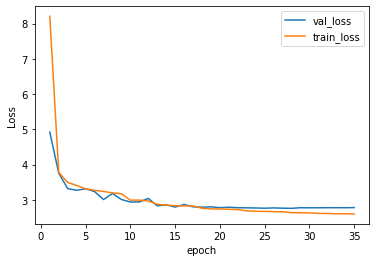

Test MSELoss:  2.7437236


Processing...
Done!
Processing...
Done!
Processing...
Done!


Epoch:  1/50 | Training MSELoss:  44.45247 | Validation MSELoss:  3.8240995
Epoch:  2/50 | Training MSELoss:  3.64373 | Validation MSELoss:  3.382683
Epoch:  3/50 | Training MSELoss:  3.4045134 | Validation MSELoss:  3.1130457
Epoch:  4/50 | Training MSELoss:  3.3684924 | Validation MSELoss:  3.1679728
Epoch:  5/50 | Training MSELoss:  3.326397 | Validation MSELoss:  3.049369
Epoch:  6/50 | Training MSELoss:  3.2577977 | Validation MSELoss:  3.233898
Epoch     7: reducing learning rate of group 0 to 5.0000e-03.
Epoch:  7/50 | Training MSELoss:  3.2408047 | Validation MSELoss:  3.1633494
Epoch:  8/50 | Training MSELoss:  3.0648756 | Validation MSELoss:  2.9088764
Epoch:  9/50 | Training MSELoss:  3.0521774 | Validation MSELoss:  2.923861
Epoch    10: reducing learning rate of group 0 to 2.5000e-03.
Epoch:  10/50 | Training MSELoss:  3.047515 | Validation MSELoss:  2.9673002
Epoch:  11/50 | Training MSELoss:  2.9379766 | Validation MSELoss:  2.86082
Epoch:  12/50 | Training MSELoss:  2.9

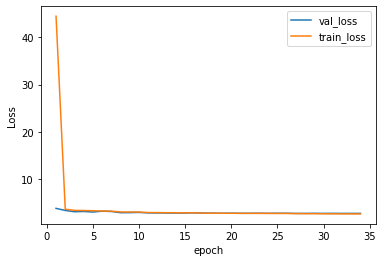

Test MSELoss:  2.8776264


In [ ]:
for i in range(2,4):
    train_fn(val_batch=i, test_batch=(i+1)%10)

In [12]:
files = os.listdir('/content/drive/MyDrive/Muon project')
df = pd.concat([pd.read_csv('/content/drive/MyDrive/Muon project/'+i).drop(columns = ['Unnamed: 0']) for i in files if 'OOF_preds_' in i])
df.to_csv('/content/drive/MyDrive/Muon project/OOF_preds.csv')

In [13]:
df = pd.read_csv('/content/drive/MyDrive/Muon project/OOF_preds.csv').drop(columns = ['Unnamed: 0'])
df = df.sort_values(by = 'row').reset_index(drop = True)
df['True_pT'] = df['true_value']
df['Predicted_pT'] = df['preds1']

In [19]:
df_cnn = pd.read_csv('/content/drive/MyDrive/Muon project/OOF_preds.csv')
df_cnn = df_cnn.sort_values(by = 'row').reset_index(drop = True)
df_cnn['True_pT'] = df_cnn['true_value']
df_cnn['Predicted_pT'] = df_cnn['preds1']

In [20]:
df_cnn

,Unnamed: 0,true_value,preds1,preds2,row,True_pT,Predicted_pT
0,6320,2.654788,2.527252,0.405557,2,2.654788,2.527252
1,13676,3.647295,3.169314,0.313439,12,3.647295,3.169314
2,61004,5.698416,4.776043,0.218404,24,5.698416,4.776043
3,34601,2.771251,3.051145,0.315488,27,2.771251,3.051145
4,16495,6.097350,10.141553,0.098192,28,6.097350,10.141553
...,...,...,...,...,...,...,...
133059,37124,3.834128,4.266388,0.237084,665307,3.834128,4.266388
133060,48879,46.706646,44.069004,0.023468,665314,46.706646,44.069004
133061,52348,16.041309,8.516409,0.103191,665315,16.041309,8.516409
133062,2254,2.047531,2.283724,0.437549,665317,2.047531,2.283724


In [21]:
df

,true_value,preds1,preds2,row,True_pT,Predicted_pT
0,2.654788,2.527252,0.405557,2,2.654788,2.527252
1,3.647295,3.169314,0.313439,12,3.647295,3.169314
2,5.698416,4.776043,0.218404,24,5.698416,4.776043
3,2.771251,3.051145,0.315488,27,2.771251,3.051145
4,6.097350,10.141553,0.098192,28,6.097350,10.141553
...,...,...,...,...,...,...
133059,3.834128,4.266388,0.237084,665307,3.834128,4.266388
133060,46.706646,44.069004,0.023468,665314,46.706646,44.069004
133061,16.041309,8.516409,0.103191,665315,16.041309,8.516409
133062,2.047531,2.283724,0.437549,665317,2.047531,2.283724


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

def MAE(df):
    MAE1 = []
    dx = 0.5
    for i in range(int(2/dx),int(150/dx)):
        P = df[(df['True_pT']>=(i-1)*dx)&(df['True_pT']<=(i+1)*dx)]
        try:
            p = mae(P['True_pT'],P['Predicted_pT'])
        except:
            p=0
        MAE1.append(p)
    MAE1 = MAE1[:236]
    return MAE1

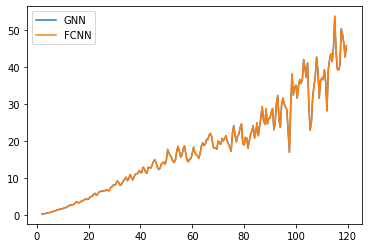

In [23]:
dx = 0.5
MAE1 = MAE(df)
plt.plot([i*dx for i in range(4,240)],MAE1,label = 'GNN')
plt.plot([i*dx for i in range(4,240)],MAE(df_cnn),label = 'FCNN')
plt.legend()
plt.show()

In [ ]:
print(sum(MAE1[:196]))

2789.781290579113


In [ ]:
def pT_classes(x):
    if x>=25:
        return 'Above 25 GeV'
    else:
        return 'Below 25 GeV'

print(classification_report(df['True_pT'].apply(pT_classes), df['Predicted_pT'].apply(pT_classes)))

              precision    recall  f1-score   support

Above 25 GeV       0.89      0.80      0.84     12508
Below 25 GeV       0.98      0.99      0.98    120556

    accuracy                           0.97    133064
   macro avg       0.94      0.89      0.91    133064
weighted avg       0.97      0.97      0.97    133064

